<a href="https://colab.research.google.com/github/vinodgaitonde/ProjIdeas/blob/main/NextWordPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import tensorflow as tf
#import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

# Read the Data from the file

In [4]:
with open('./sample_data/1661-split.txt', 'r', encoding='utf-8') as file:
    text = file.read()

#with open('./sample_data/1661-split.txt', 'r') as f:
#    text = f.read().lower()
print('corpus length:', len(text))
print(text[:100])

corpus length: 282300
﻿
Project Gutenberg's The Adventures of Sherlock Holmes, by Arthur Conan Doyle

This eBook is for th


# Tokenize and Create Uniue Word Dictionary
Now split the dataset into each word in order but without the presence of some special characters.

In [5]:
#tokenizer = RegexpTokenizer(r'[^a-zA-Z0-9\s]', '')
#tokenizer = RegexpTokenizer(r'\w+')
#words = tokenizer.tokenize(text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
# Get the word index
word_index = tokenizer.word_index

total_words = len(tokenizer.word_index) + 1

print("tokenizer.word_index: ",len(tokenizer.word_index))
print("total_words: ",total_words)
#print first 100 words
print("word_index : ",tokenizer.word_index)

tokenizer.word_index:  6152
total_words:  6153
word_index :  {'the': 1, 'and': 2, 'of': 3, 'to': 4, 'a': 5, '”': 6, 'i': 7, 'in': 8, 'that': 9, 'he': 10, 'it': 11, 'was': 12, 'his': 13, 'you': 14, 'is': 15, 'as': 16, 'have': 17, 'with': 18, 'my': 19, 'had': 20, 'which': 21, 'at': 22, 'for': 23, 'not': 24, 'be': 25, 'me': 26, 'but': 27, 'upon': 28, 'from': 29, 'holmes': 30, 'him': 31, 'said': 32, 'we': 33, 'there': 34, 'this': 35, 'been': 36, 'so': 37, 'on': 38, '“i': 39, 'very': 40, 'all': 41, 'by': 42, 'an': 43, 'she': 44, 'one': 45, 'her': 46, 'are': 47, 'were': 48, 'would': 49, 'your': 50, 'man': 51, 'when': 52, 'no': 53, 'out': 54, 'mr': 55, 'what': 56, 'up': 57, 'do': 58, 'could': 59, 'then': 60, 'some': 61, '’': 62, 'has': 63, 'will': 64, 'who': 65, 'little': 66, 'down': 67, 'if': 68, 'or': 69, 'see': 70, 'into': 71, 'may': 72, 'am': 73, 'now': 74, 'us': 75, 'they': 76, 'come': 77, 'know': 78, 'can': 79, 'must': 80, 'more': 81, 'over': 82, 'about': 83, 'than': 84, 'should': 85, '

Create the n-gram

In [6]:
input_sequences = []
#j=0
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    #if(j<5):
    #    print(j, line)
    #    print(token_list)
    #    j+=1
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        #print ("\n", n_gram_sequence)
        input_sequences.append(n_gram_sequence)


print("input_sequences count",len(input_sequences))
#print("input_sequences",input_sequences[:5])
print("0 input sequence", input_sequences[0])
print("1 input sequence", input_sequences[1])
print("2 input sequence", input_sequences[2])
print("3 input sequence", input_sequences[3])
print("4 input sequence", input_sequences[4])

input_sequences count 49381
0 input sequence [1230, 3003]
1 input sequence [1230, 3003, 1]
2 input sequence [1230, 3003, 1, 698]
3 input sequence [1230, 3003, 1, 698, 3]
4 input sequence [1230, 3003, 1, 698, 3, 107]


#Pad and make all sequence the same length
padding should be added at the beginning of each sequence using the ‘padding=pre’ argument.


In [7]:
max_sequence_len = max([len(seq) for seq in input_sequences])
print("max_sequence_len", max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

max_sequence_len 20


#Prepare features(n-gram) against label
Let's create two numpy arrays x for storing the features and y for storing its corresponding label.

We will iterate x and y if the word is available so that the corresponding position becomes 1

In [8]:
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
print(X.shape)
print(y.shape)

print(X[:5])
print(y[0])
print(y[1])
print(y[2])
print(y[3])
print(y[4])

(49381, 19)
(49381,)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 1230]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 1230 3003]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 1230 3003    1]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 1230 3003    1  698]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1230 3003    1  698    3]]
3003
1
698
3
107


Converting the output array into a suitable format for training a model, where each target word is represented as a binary vector.

In [9]:
y = np.array(tf.keras.utils.to_categorical(y, num_classes=total_words))
print(np.shape(y))

(49381, 6153)


#Build Recurrent Neural Network
1.   The first layer added to the model is the ‘Embedding’ layer, which is responsible for converting the input sequences into dense vectors of fixed size. It takes three arguments:


*   ‘total_words’, which represents the total number of distinct words in the vocabulary;
*   ‘100’, which denotes the dimensionality of the word embeddings
*   ‘input_length’, which specifies the length of the input sequences.



2.   The next layer added is the ‘LSTM’ layer, a type of recurrent neural network (RNN) layer designed for capturing sequential dependencies in the data. It has 150 units, which means it will learn 150 internal representations or memory cells.

3.   Finally, the ‘Dense’ layer is added, which is a fully connected layer that produces the output predictions. It has ‘total_words’ units and uses the ‘softmax’ activation function to convert the predicted scores into probabilities, indicating the likelihood of each word being the next one in the sequence.

In [10]:
print("total_words",total_words)
print("max_sequence_len",max_sequence_len)

model = Sequential()
#model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
#model.add(LSTM(150))
#model.add(Dense(total_words, activation='softmax'))

model = Sequential([
    Embedding(total_words, 100, input_length=max_sequence_len-1),
    LSTM(150),
    Dense(total_words, activation='softmax')
])

print(model.summary())

total_words 6153
max_sequence_len 20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Train the next word prediction model with 20 epochs

In [11]:
#optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.2, batch_size=128, epochs=60, shuffle=True).history

Epoch 1/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.0523 - loss: 6.9724 - val_accuracy: 0.0534 - val_loss: 6.4831
Epoch 2/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.0607 - loss: 6.1303 - val_accuracy: 0.0660 - val_loss: 6.4521
Epoch 3/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.0691 - loss: 5.9233 - val_accuracy: 0.0805 - val_loss: 6.3511
Epoch 4/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.0860 - loss: 5.7610 - val_accuracy: 0.0959 - val_loss: 6.2532
Epoch 5/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1091 - loss: 5.4858 - val_accuracy: 0.1075 - val_loss: 6.1998
Epoch 6/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1265 - loss: 5.2994 - val_accuracy: 0.1116 - val_loss: 6.1968
Epoch 7/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1360 - loss: 5.1590 - val_accuracy: 0.1146 - val_loss: 6.2147
Epoch 8/60
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1466 - loss: 5.0444 - val_acc

#Save the Model

In [12]:
model.save('next_Word_16_Nov_v1.h5')
model.save('next_Word_16_Nov_v1.keras')

#Download the Model

In [13]:
from google.colab import files
files.download('next_Word_16_Nov_v1.h5')
files.download('next_Word_16_Nov_v1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Save the model

In [14]:
#model.save('grp10_nextWord_1.keras')
#with open('training_history.pickle', 'wb') as f:
#    pickle.dump(history.history, f)
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_Word_16_Nov_v1.keras')
history = pickle.load(open("history.p", "rb"))

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Evaluate the Next word Predition Model

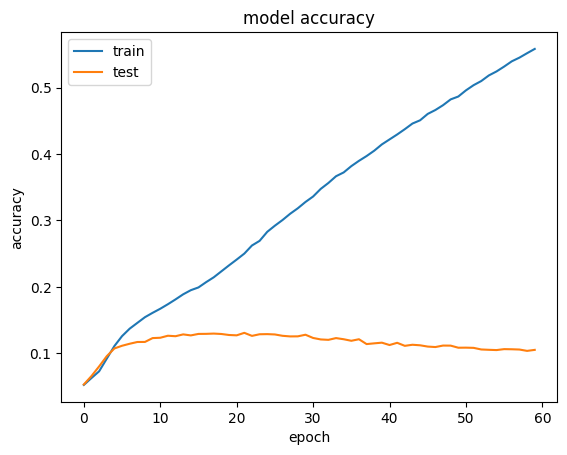

In [15]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

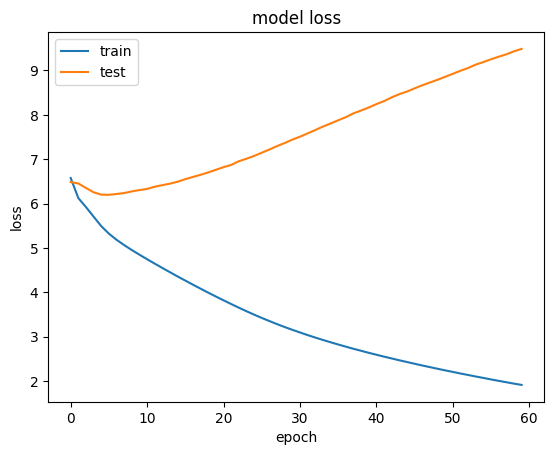

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Test Next Word Prediction Model

In [2]:
#seed_text = "she is incorrigible, and my"
#next_words = 3
#def predict_next_n_words(seed_text, next_words):
def predict_next_n_words(seed_text):
    predicted_next_n_words = ""
    for _ in range(1):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        preds = model.predict(token_list, verbose=0)
        #print(preds[0][303])
        #print(preds[0][304])
        #print("preds",preds)
        #print(preds.shape)
        predicted = np.argmax(preds, axis=-1)
        index=predicted[0]
        #print(predicted.shape)
        #print("predicted", predicted)

        output_word = ""

        # Get the word at the given index from the word_index
        output_word=list(word_index.keys())[list(word_index.values()).index(index)]

        # print("predicted", output_word)
        """
        for word, index in tokenizer.word_index.items():
            print("word",word)
            print("index",index)
            if index == predicted:
                output_word = word
                break
        """
        seed_text += " " + output_word
        predicted_next_n_words += " " + output_word

       #print(save_seed_text)
        #print(output_word)
    return predicted_next_n_words

def predict_next_word_top_options(seed_text, num_words):
    predicted_words = []
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    preds = model.predict(token_list,verbose=0)[0]
    # Get the indices of the  n largest elements from an iterable.
    # find out the top predictions from preds
    top_indices = heapq.nlargest(num_words, range(len(preds)), preds.take)
    #print(top_indices)
    # Get the corresponding words from the unique word index
    predicted_words = [list(word_index.keys())[list(word_index.values()).index(i)] for i in top_indices]
    return predicted_words


seed_text = "she is incorrigible, and my"
next_words = 5
#result = predict_next_n_words(seed_text, next_words)
result = predict_next_n_words(seed_text)
print("Seed Text: she is incorrigible, and my")
print(result)

result = predict_next_word_top_options(seed_text, 5)
print(result)

NameError: name 'tokenizer' is not defined

In [1]:
"""
quotes = [
    "she is incorrigible, and my",
    "It is not a lack of love but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]
"""
quotes = [
    "she is incorrigible, and my",
    "It is not a lack of love but a lack of friendship",
    "That which does not kill us makes ",
    "I'm not upset that you lied to me, I'm upset that from",
    "And those who were seen dancing were thought to be insane",
    "It is hard enough to remember my opinions, without"
]
print("***** NEXT 5 WORDS *****")
for q in quotes:

    if(len(q)>1000):
        seq = q[:40].lower()
    else:
        seq = q.lower()

    #predicted_words = predict_next_n_words(seq,5)
    predicted_words = predict_next_n_words(seq)
    print(f"Input Text: {seq}")
    print(f"Predicted Next Words: {predicted_words}\n")

print("***** ***** ***** *****")

print("***** NEXT WORD OPTIONS *****")
for q in quotes:
    if(len(q)>1000):
        seq = q[:40].lower()
    else:
        seq = q.lower()
    predicted_words = predict_next_word_top_options(seq,5)
    print(f"Input Text: {seq}")
    print(f"Predicted Next Words: {predicted_words}\n")

print("***** ***** ***** *****")

***** NEXT 5 WORDS *****


NameError: name 'predict_next_n_words' is not defined

# Take inputs from user for text prediction

In [19]:
while(True):
  text = input("Enter your line: ")

  if text == "0":
      print("Execution completed.....")
      break

  else:
      try:
          text = text.split(" ")
          text = text[-6:]
          print(text)

          predict_next_n_words(model, tokenizer, text)

      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: she is incorrigible, and my
['she', 'is', 'incorrigible,', 'and', 'my']
Error occurred:  predict_next_n_words() takes 2 positional arguments but 3 were given


KeyboardInterrupt: Interrupted by user